In [1]:
from numba import jit, cuda
import warnings
import cv2
import numpy as np
import math
import random
import time as timess
from prettytable import PrettyTable
from IPython.display import clear_output, Markdown, display

def db_to_normal(x):
    return 10**(x/10)

def normal_to_db(x):
    return 10*math.log10(x)

base_noise_min=db_to_normal(-1000)
base_noise_max=db_to_normal(-75)

ci=0#len(time)//4
cf=10000

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

In [2]:
# rf = open("Radar_G_table.txt", "w")
# f = open("G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     rf.write(str(j/10))
#     rf.write(' | ')
#     for i in range(360):
#         if((i>=0 and i<=90) or (i>=270 and i<360)):
#             f.write(str(math.cos(math.radians(i)))+' ')
#             rf.write(str(math.cos(math.radians(i)))+' ')
#         else:
#             f.write(str(0)+' ')
#             rf.write(str(0)+' ')
#     f.write('\n')
#     rf.write('\n')
# f.close()    
# rf.close()  

# f = open("angle_table.txt", "w")
# for th in range(-45,45):
#     a1=round(normal_to_db(P*math.cos(math.radians(45+th))),4)
#     a2=round(normal_to_db(P*math.cos(math.radians(45-th))),4)
#     f.write(str(round(a2-a1,5))+',')
# th=45
# a1=round(normal_to_db(P*math.cos(math.radians(45+th))),4)
# a2=round(normal_to_db(P*math.cos(math.radians(45-th))),4)
# f.write(str(round(a2-a1,5)))
# f.close()


G_table={}
f = open("G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    G_table[tmp_freq]=[]
    for i in tmp:
        G_table[tmp_freq].append(float(i))
f.close()

Radar_G_table={}
f = open("Radar_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for i in tmp:
        Radar_G_table[tmp_freq].append(float(i))
f.close()

f = open("angle_table.txt", "r")
angle_table=tuple(map(float,f.read().split(',')))
f.close()

In [3]:
class radar:
    def __init__(self, id,pri=500,pwd=10,pos=(0,0),heading=0,radarWaypoints=[]):
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = (10**1)*1                                # Peak transmitted power
        self.freq = 10.0                                   # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.impedance = 50
        self.pos = radarWaypoints[0]
        self.speed=10
        self.radarWaypoints=radarWaypoints
        self.next_waypoint=1
    def move_radar(self):
        if(len(self.radarWaypoints)>1):
            time_diff=1
            cur_pos=list(self.pos)
            next_waypoint=self.next_waypoint
            d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.radarWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.radarWaypoints)*2):
                    raise Exception("Radar "+self.id+"'s speed is too much")
                d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            heading=math.degrees(math.atan2(self.radarWaypoints[next_waypoint][1] - cur_pos[1],self.radarWaypoints[next_waypoint][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.pos=cur_pos
            self.next_waypoint=next_waypoint
    def __del__(self):
        pass
class aircraft:
    def __init__(self, id,pos=(0,0),heading=0,receivers=4,aircraftWaypoints=[]):
        self.id = id                                       # Id of the Aircraft
        self.pos = aircraftWaypoints[0]                    # Position of the radar
        self.heading = heading                             # heading of the Aircraft in degrees
        self.receivers_n = receivers                       # Number of antenna's in the RWR
        self.speed=10
        self.aircraftWaypoints=aircraftWaypoints
        self.next_waypoint=1
    def move_aircraft(self):
        if(len(self.aircraftWaypoints)>1):
            time_diff=1
            cur_pos=list(self.pos)
            next_waypoint=self.next_waypoint
            d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.aircraftWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.aircraftWaypoints)*2):
                    raise Exception("Aircraft speed is too much")
                d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            heading=math.degrees(math.atan2(self.aircraftWaypoints[next_waypoint][1] - cur_pos[1],self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.pos=cur_pos
            self.next_waypoint=next_waypoint
    
    def __del__(self):
        pass
    

In [4]:
def signal_generator(radar,aircraft,i):
    global G_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n
    pri = radar.pri                               # Pulse Repetition Interval
    pwd = radar.pwd                               # Pulse Width
    R = math.dist(radar.pos,aircraft.pos)         # Distance between the radar and the aircraft
    Pt = radar.Pt                                 # Peak transmitted power
    freq = radar.freq                             # carrier frequency
    # Lambda=3*(10**8)/radar.freq
    Lambda=2
    angle=math.degrees(math.atan2(radar.pos[1]-aircraft.pos[1],radar.pos[0]-aircraft.pos[0]))-aircraft.heading
    while(angle>=360):
        angle-=360                                     # Angle between the aircraft's front direction and radar
    while(angle<0):
        angle+=360
    angle_rad = radar.heading
    angle_t=int(angle-angle_rad-180-(360-aircraft.heading))
    while(angle_t>=360):
        angle_t-=360                                     # Angle between the radar's boresight and aircraft
    while(angle_t<0):
        angle_t+=360
    angle_radar = angle_t
    P=(Pt*Radar_G_table[freq][angle_t]*(Lambda**2))/((4*math.pi*R)**2)  # Power recieved by the aircraft radar reciver
    a=0.1
    omega=2*np.pi*18/10
    angl_cond=[]
    loss=8
    pulse_train_angles=[]
    pulse_train_frequency=[]
    pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
    for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
        angl_cond.append((360/receivers_n)*(1+2*j)/2)     # based on the above information
        pulse_train.append([])
    for j in range(rwr_antenna_n-receivers_n):
        pulse_train.append([])
    # for i in range(-1,len(time)-1):
    if(i%pri<=pwd):
        pulse_train_angles.append(angle)
        pulse_train_frequency.append(freq)
        idx=0
        for j in pulse_train:
            tmp_n=random.uniform(base_noise_min,base_noise_max)
            tmp_v=abs(P*G_table[freq][int(angle-angl_cond[idx])])
            tmp_f=tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1))
            j.append(tmp_f)
            idx+=1
    else:
        pulse_train_angles.append(0)
        pulse_train_frequency.append(0)
        for j in pulse_train:
            j.append(random.uniform(base_noise_min,base_noise_max))
    return pulse_train,pulse_train_angles,pulse_train_frequency

def closest(lst, K):
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return idx

In [5]:
rwr_antenna_n = 4              # Number of recievers on the aircraft(4 or 6)
radars_n = 3                   # Number of radars
receivers_n = 4 # Effective number of antenna

img = np.zeros((700,1400,3), np.uint8)

aircraft_waypoints = [(221, 469), (216, 174), (1237, 160), (1237, 478), (682, 650)]
aircraft_0 = aircraft(id=0,heading=random.uniform(0,360),receivers=receivers_n,aircraftWaypoints=aircraft_waypoints[:])
# aircraft_0 = aircraft(id=0,heading=0,receivers=receivers_n,aircraftWaypoints=aircraft_waypoints)

radar_positions = np.array([
                            (655.0, 466.0),
                            (39.0, 500.0),
                            (50.0, 42.0),
                            (1355.0, 670.0),
                           ])
radar_waypoints = [[]]*len(radar_positions)
radar_waypoints = list([[radar_positions[0]]+[(829, 384), (505, 383)]
                       ,[radar_positions[1]]
                       # ,[radar_positions[2]]
                       # ,[radar_positions[3]]
                       ])
radars_n=len(radar_waypoints)
radars=[]
pulses=[]                         
for i in range(rwr_antenna_n+1):                          
    pulses.append([])
pris=[400,550,750]
for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.pos[1]-radar_positions[j][1],aircraft_0.pos[0]-radar_positions[j][0])))#+180
    heading_noise_range=0
    # rand_pri=int(np.random.normal(loc=150, scale=70000, size=(1))[0])
    rand_pri=int(random.uniform(100,1000))
    # radar_j = radar(id=j,pri=rand_pri,pwd=15,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),radarWaypoints=radar_waypoints[j])
    radar_j = radar(id=j,pri=pris[j],pwd=15,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),radarWaypoints=radar_waypoints[j])
    rand_freq=(int(random.uniform(0,18)))
    radar_j.freq=0.5+rand_freq
    radars.append(radar_j)
    del radar_j;
print('Aircraft and it\'s description')
t = PrettyTable(['Id','Number of RWR antenna\'s'])
i=aircraft_0
t.add_row([i.id+1,i.receivers_n])
print(t)
print('Radars and their description')
t = PrettyTable(['Id', 'Peak transmitted power(db)','frequency (GHZ)','Pulse Repetition Interval(100 pico seconds)','Pulse Width(100 pico seconds)'])
for i in radars:
    t.add_row([i.id+1,10*math.log10(i.Pt),i.freq,i.pri,i.pwd])
print(t)

Aircraft and it's description
+----+-------------------------+
| Id | Number of RWR antenna's |
+----+-------------------------+
| 1  |            4            |
+----+-------------------------+
Radars and their description
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+
| Id | Peak transmitted power(db) | frequency (GHZ) | Pulse Repetition Interval(100 pico seconds) | Pulse Width(100 pico seconds) |
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+
| 1  |            10.0            |       17.5      |                     400                     |               15              |
| 2  |            10.0            |       3.5       |                     550                     |               15              |
+----+----------------------------+-----------------+---------------------------------------------+-----------------

In [6]:
tmp_s_r=20
tmp_s_a=20
aircraft_0.speed=2
for i in radars:
    i.speed=1

frame = np.zeros((500,1000,3), np.uint8)
pulse_train_angles=[]
pulse_train_frequency=[]
pulse_train=[]
pulse_train_f=[]
for j in range(rwr_antenna_n):
    pulse_train.append([])
    for i in range(len(radars)):
        pulse_train[-1].append([])
    pulse_train_f.append([])
mov_offset=0
tmp_pdw={}
pdw=[]
counter=[]
max_amplitude=[]
list_init=[]
fall_flag=[]
lead_flag=[]
increasing_count=[]
increasing_flag=[]
top_points=[]
for j in range(rwr_antenna_n):
    counter.append(0)
    max_amplitude.append(0)
    increasing_count.append(0)
    list_init.append([])
    top_points.append([])
    increasing_flag.append(0)
    fall_flag.append(True)
    lead_flag.append(True)

idx=0
play_flag=True
visualize=0
time = 10**4 #in nano seconds 
while idx<time:
# for idx in range(60):
    # in_tim=timess.time()
    if(play_flag):
        if(0):
            if(idx%10==0):
                aircraft_0.move_aircraft()
                for i in radars:
                    i.move_radar()
        airc_pos=(int(aircraft_0.pos[0]),int(aircraft_0.pos[1]))
        if(visualize):
            # adding the aircraft to the image
            img = np.zeros(img.shape, np.uint8)
            for j in range(receivers_n):
                cv2.line(img, airc_pos, 
                         (int(airc_pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2)))),
                          int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))), (0,0,255), 2)
            cv2.circle(img, airc_pos, 5, (0,255,0), -1)
            airc_head=(int(airc_pos[0]+(tmp_s_a*1.5*math.cos(math.radians(aircraft_0.heading)))),int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading)))))
            cv2.line(img, airc_pos, airc_head, (0,255,0), 2)            
        #generating signals
        max_t=[]
        max_t_a=set()
        max_t_f=set()
        for j in range(rwr_antenna_n):
            max_t.append([])
        for j in range(len(radars)):
            radar_pos=(int(radars[j].pos[0]),int(radars[j].pos[1]))
            heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
            heading_noise_range=0
            radars[j].heading=heading_angle#random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
            pulse_train_r,pulse_train_angles_r,pulse_train_frequency_r=signal_generator(radars[j],aircraft_0,idx)
            for k in range(len(pulse_train_r)):
                max_t[k].append(pulse_train_r[k][0])
                pulse_train[k][j].append(pulse_train_r[k][0])
            if(pulse_train_angles_r[0]!=0):
                max_t_a.add(pulse_train_angles_r[0])
            if(pulse_train_frequency_r[0]!=0):
                max_t_f.add(pulse_train_frequency_r[0])
            if(visualize):
                # adding the radars to the image
                cv2.circle(img, radar_pos, 5, (255,0,0), -1)
                cv2.line(img, radar_pos, 
                         (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(radars[j].heading)))),
                          int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(radars[j].heading))))), (0,0,255), 2) 
        # making the graph move
        if(idx>=frame.shape[1]-1):
        # if(i-mov_offset>200):
            off_spd=1
            mov_offset+=off_spd
            tmp=frame[:,off_spd:,:].copy()
            frame[:,:-off_spd,:]=tmp.copy()
        # generating th pdw's
        if(len(max_t_a)==1):
            pulse_train_angles.append(list(max_t_a)[0])
        else:
            pulse_train_angles.append(0)
        if(len(max_t_a)==1):
            pulse_train_frequency.append(list(max_t_f)[0])
        else:
            pulse_train_frequency.append(0)
        all_fall=0
        tmp_counter=[]
        tmp_amplitude=[]
        for j in range(len(max_t)):
            pulse_train_f[j].append(max(max_t[j]))
            if(idx>0):
                if(visualize):
                    # drawing the graph on the image
                    cv2.line(frame,
                             (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][idx-1]*10000000)-10),
                             (idx-mov_offset,frame.shape[0]*(j+1)//4-int(pulse_train_f[j][ idx ]*10000000)-10),
                             (0,0,255),1)
            if(pulse_train_f[j][-1]>base_noise_max):
                if not(lead_flag[j]):
                    lead_flag[j]=True # Rising edge
                    if(len(tmp_pdw)==0):
                        tmp_pdw['TOA']=idx
                if(pulse_train_f[j][-1]>max_amplitude[j]):
                    max_amplitude[j]=pulse_train_f[j][-1]
                counter[j]+=1
                fall_flag[j]=False
            else:
                if not(fall_flag[j]):
                    fall_flag[j]=True # Falling edge
                    tmp_counter.append(counter[j])
                tmp_amplitude.append(max_amplitude[j])
                lead_flag[j]=False
                max_amplitude[j]=0
                counter[j]=0
                all_fall+=1
        if(all_fall==len(max_t) and len(tmp_pdw)!=0):
            round_digits=2
            tmp_pdw['TOA']=tmp_pdw['TOA']+int(random.uniform(-10,10))
            tmp_pdw['PWD']=max(tmp_counter)-1
            tmp_pdw['Frequency (GHz)']=round(max(pulse_train_frequency[tmp_pdw['TOA']:tmp_pdw['TOA']+tmp_pdw['PWD']]),2)
            tmp_pdw['Frequency (GHz)']=abs(round(tmp_pdw['Frequency (GHz)']+(random.uniform(-0.001,0.001) if tmp_pdw['Frequency (GHz)']>0 else 0),4))
            amp_unit='dbm'
            freq_app=True
            freq_mod=False
            Freq=0
            amlitudes=[]
            for j in range(len(max_t)):
                amp_value=tmp_amplitude[j]
                # print(amp_value,idx)
                # round(normal_to_db(amp_value),round_digits)
                if(amp_value==0):
                    amp_value=0
                else:
                    amp_value=normal_to_db(amp_value*1000)+85
                    amp_value=round(amp_value,round_digits)
                    if(amp_value<10):
                        amp_value=0
                amlitudes.append(amp_value)
                if(j==0):
                    tmp_pdw['A1 ('+str(amp_unit)+')']=(amp_value)
                elif(j==1):
                    tmp_pdw['A2 ('+str(amp_unit)+')']=(amp_value)
                elif(j==2):
                    tmp_pdw['A3 ('+str(amp_unit)+')']=(amp_value)
                elif(j==3):
                    tmp_pdw['A4 ('+str(amp_unit)+')']=(amp_value)
                    
                    
            # tmp_pdw['AOA (Degrees)']=round(max(pulse_train_angles[tmp_pdw['TOA']:tmp_pdw['TOA']+tmp_pdw['PWD']]),round_digits)
            # tmp_pdw['AOA (Degrees)']=[]
            amp_ind=[]
            amp_cnt=0
            AOA=[]
            for amps in amlitudes:
                amp_cnt+=1
                if amps > 10:
                    amp_ind.append(amp_cnt)
                    # tmp_pdw[''].append((amps,amp_ind))
                    AOA.append(amps)
            if(len(amp_ind)==2):
                if(amp_ind[0]==1 and amp_ind[1]==4):
                    t_ang=360-(closest(angle_table,round(AOA[1]-AOA[0],round_digits))-45)
                    if(t_ang>=360):
                        t_ang-=360
                    tmp_pdw['AOA (Degrees)']=t_ang
                elif(amp_ind[0]==1 and amp_ind[1]==2):
                    tmp_pdw['AOA (Degrees)']=90+(closest(angle_table,round(AOA[1]-AOA[0],round_digits))-45)
                elif(amp_ind[0]==2 and amp_ind[1]==3):
                    tmp_pdw['AOA (Degrees)']=180+(closest(angle_table,round(AOA[1]-AOA[0],round_digits))-45)
                elif(amp_ind[0]==3 and amp_ind[1]==4):
                    tmp_pdw['AOA (Degrees)']=270+(closest(angle_table,round(AOA[1]-AOA[0],round_digits))-45)
            else:
                tmp_pdw['AOA from table']=0
            tmp_pdw['Freq_mod_flag']=False
            pdw.append(tmp_pdw)
            tmp_pdw={}
        idx+=1
        # print(max_t)
        # print(pulse_train_f)

        if(visualize):
            image = cv2.putText(img,'Time in nano seconds : '+str(idx//10),(img.shape[1]*6//10,img.shape[0]*1//10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1,cv2.LINE_AA)
    if(visualize):
        cv2.imshow('Visualisation',img)
        cv2.imshow('Test', frame)
        # cv2.waitKey(0)
        # break
        quit_k = cv2.waitKey(1) & 0xFF
        if quit_k == ord('q'):
            break
        if quit_k == ord('p'):
            play_flag=False
        if quit_k == ord('l'):
            play_flag=True
    # print(timess.time()-in_tim) #clock resolution
    if not (visualize):
        if(idx%100==0):
            print(idx/time)
            clear_output(wait=True)
if(visualize):
    cv2.imwrite('Visualisation.jpg',img)
    cv2.destroyAllWindows()

1.0


In [7]:
if(len(pdw)>1):
    display(Markdown('{}<strong>{}</strong>{}'.format('PDW\'s of the recieved pulses in ',str(idx//10)+' nano seconds',' are as follows')))
    t = PrettyTable(list(pdw[0].keys()))
    for i in pdw[:]:
        t.add_row(list(i.values()))
    print(t)

PDW's of the recieved pulses in <strong>1000 nano seconds</strong> are as follows

+------+-----+-----------------+----------+----------+----------+----------+---------------+---------------+
| TOA  | PWD | Frequency (GHz) | A1 (dbm) | A2 (dbm) | A3 (dbm) | A4 (dbm) | AOA (Degrees) | Freq_mod_flag |
+------+-----+-----------------+----------+----------+----------+----------+---------------+---------------+
| 408  |  15 |     17.4996     |  54.91   |  54.68   |    0     |    0     |       88      |     False     |
| 557  |  15 |      3.5006     |    0     |    0     |  62.93   |  61.17   |      259      |     False     |
| 796  |  15 |     17.4992     |  54.91   |  54.68   |    0     |    0     |       88      |     False     |
| 1107 |  15 |      3.5008     |    0     |    0     |  62.93   |  61.17   |      259      |     False     |
| 1208 |  15 |     17.5008     |  54.91   |  54.68   |    0     |    0     |       88      |     False     |
| 1602 |  15 |     17.4991     |  54.91   |  54.68   |    0     |    0     |       88      |     False     |
| 1653 |  15 |     

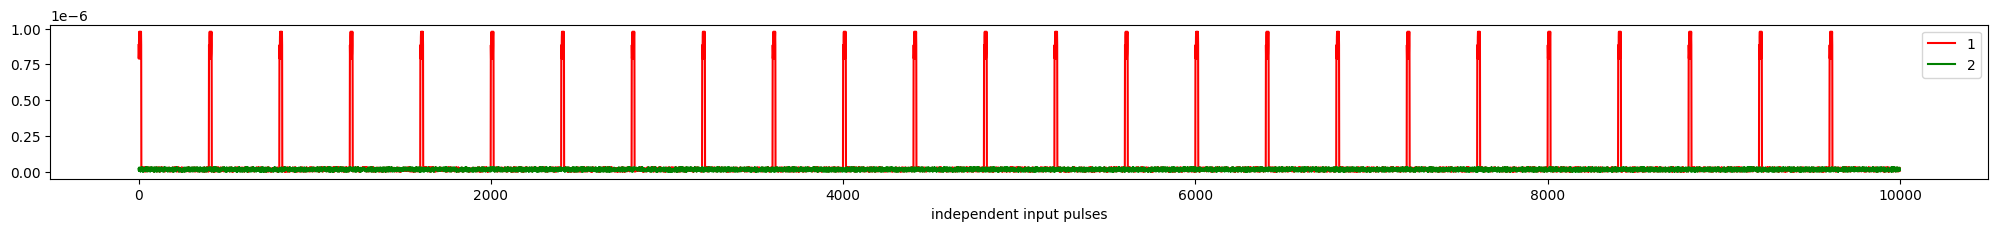

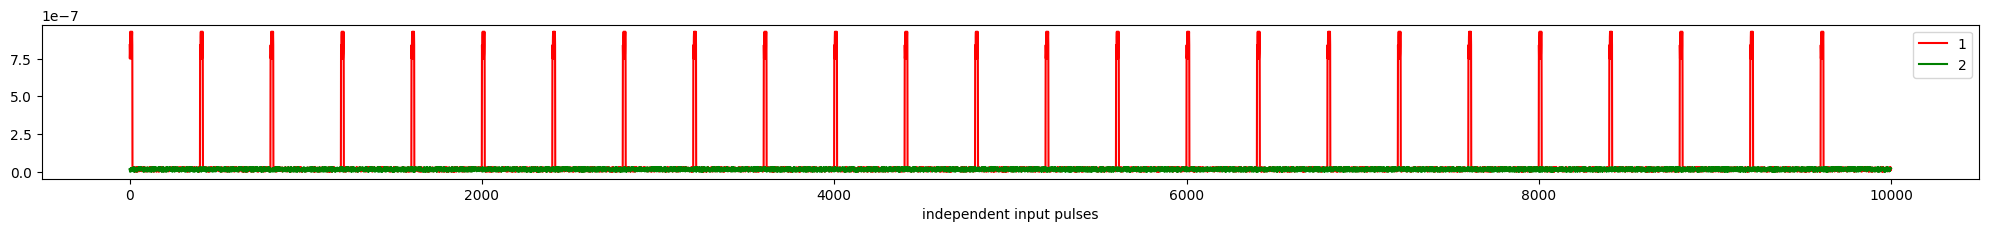

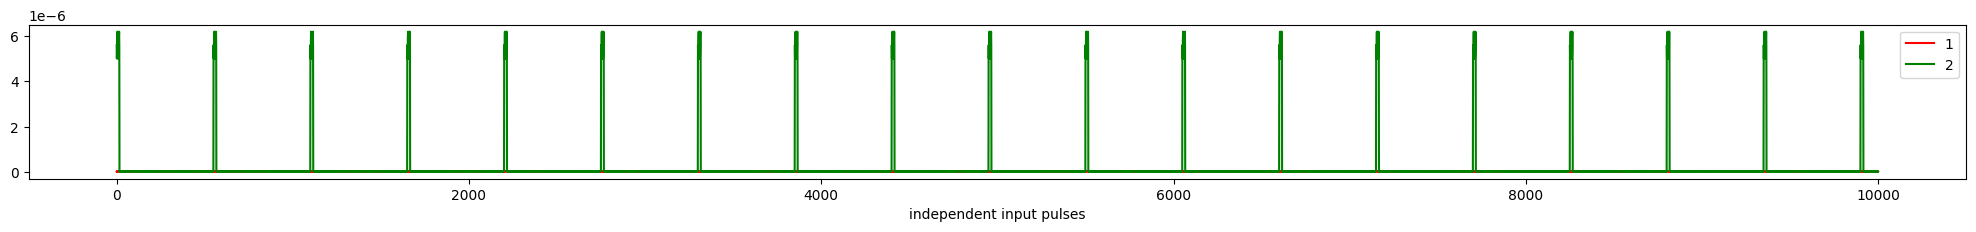

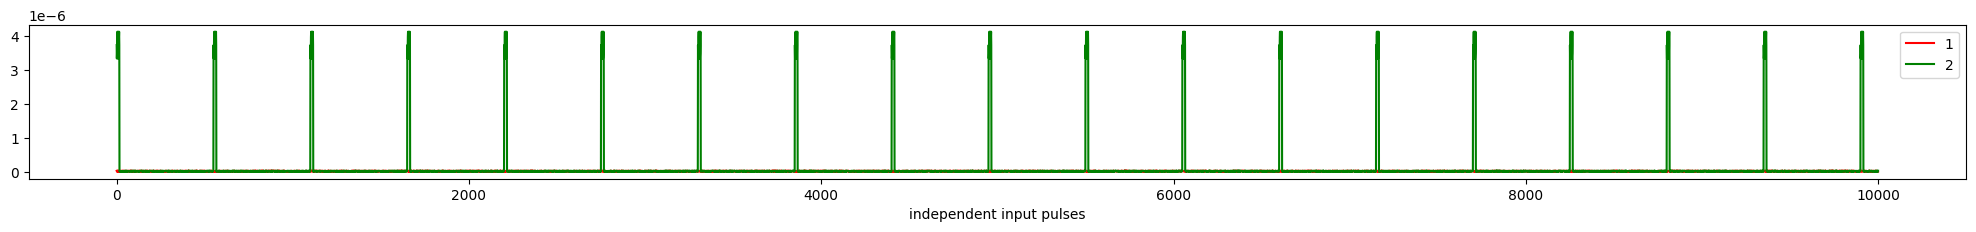

In [8]:
import matplotlib.pyplot as plt

time_l=[*range(idx)]
ci=0#len(time)//4
cf=len(time_l)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

for i in pulse_train:
    plt.figure(figsize=(fig_x , fig_y))
    jdx=0
    for j in i:
        jdx+=1
        plt.plot(time_l[ci:cf],j[ci:cf], color=clrs[jdx-1], label=str(jdx))
    plt.legend()
    plt.xlabel("independent input pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

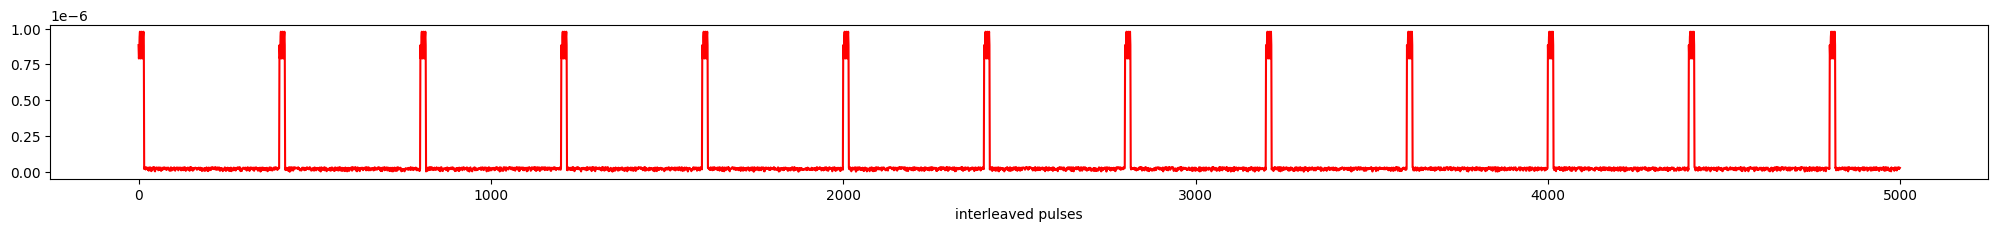

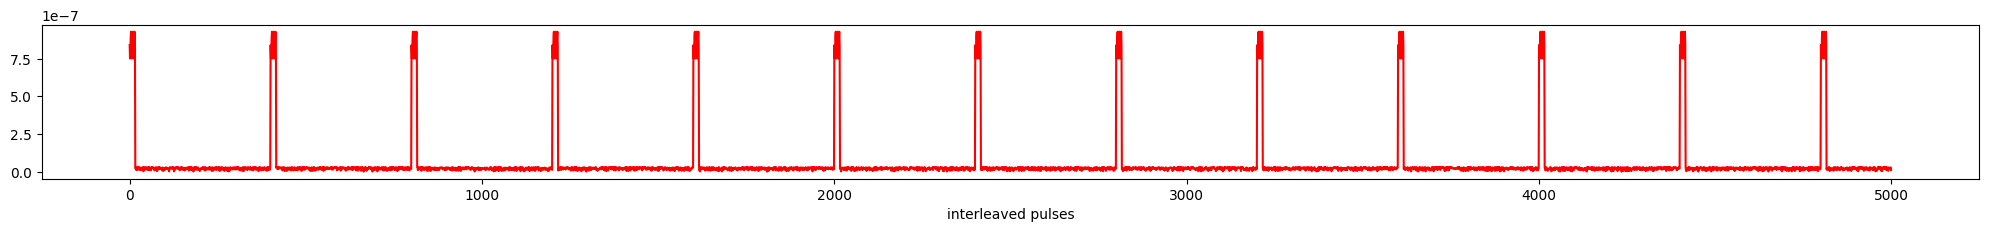

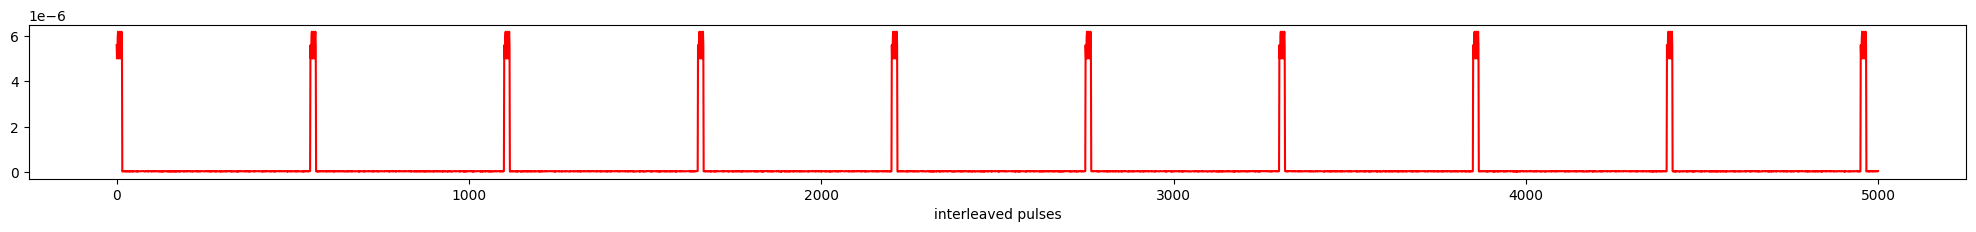

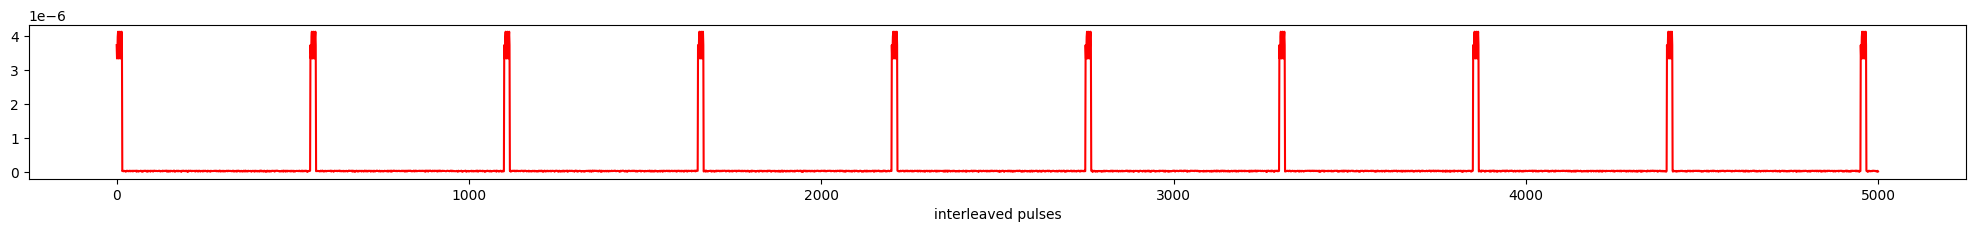

In [9]:
import matplotlib.pyplot as plt

time_l=[*range(idx)]
ci=0#len(time)//4
cf=len(time_l)//2

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'


# for i in pulse_train_angles:
for i in pulse_train_f:
    plt.figure(figsize=(fig_x , fig_y))
    plt.plot(time_l[ci:cf],i[ci:cf], color=clrs[0]) 
    plt.xlabel("interleaved pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

In [10]:
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (x,y)
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=pt1, radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     for i in radars:
#         radar_pos=(int(img.shape[1]//2+i.pos[0]),int(img.shape[0]//2+i.pos[1]))
#         radar_pos=(int(i.pos[0]),int(i.pos[1]))
#         heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
#         heading_noise_range=0
#         i.heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
#         cv2.circle(frame, radar_pos, 5, (255,0,0), -1)
#         cv2.line(frame, radar_pos, 
#                  (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(i.heading)))),
#                   int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))), (0,0,255), 2)
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [11]:
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (float(x),float(y))
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=(int(pt1[0]),int(pt1[1])), radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [12]:
# frame = np.zeros((500,2000,3), np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         break
# cv2.destroyAllWindows()

In [13]:
th=15
P=1*(10**7)
for th in range(-44,45):
    a1=round(normal_to_db(P*math.cos(math.radians(45+th))),4)
    a2=round(normal_to_db(P*math.cos(math.radians(45-th))),4)
    print(th,' | ',round(a2-a1,5))#,' | ',a1,' - ',a2)

-44  |  -17.5807
-43  |  -14.5692
-42  |  -12.806
-41  |  -11.5536
-40  |  -10.5804
-39  |  -9.7838
-38  |  -9.1086
-37  |  -8.5219
-36  |  -8.0029
-35  |  -7.5368
-34  |  -7.1135
-33  |  -6.7252
-32  |  -6.3663
-31  |  -6.0322
-30  |  -5.7194
-29  |  -5.425
-28  |  -5.1466
-27  |  -4.8823
-26  |  -4.6303
-25  |  -4.3894
-24  |  -4.1582
-23  |  -3.9359
-22  |  -3.7215
-21  |  -3.5142
-20  |  -3.3133
-19  |  -3.1182
-18  |  -2.9283
-17  |  -2.7432
-16  |  -2.5625
-15  |  -2.3856
-14  |  -2.2123
-13  |  -2.0421
-12  |  -1.8748
-11  |  -1.7101
-10  |  -1.5477
-9  |  -1.3874
-8  |  -1.2289
-7  |  -1.0719
-6  |  -0.9163
-5  |  -0.7618
-4  |  -0.6084
-3  |  -0.4556
-2  |  -0.3035
-1  |  -0.1516
0  |  0.0
1  |  0.1516
2  |  0.3035
3  |  0.4556
4  |  0.6084
5  |  0.7618
6  |  0.9163
7  |  1.0719
8  |  1.2289
9  |  1.3874
10  |  1.5477
11  |  1.7101
12  |  1.8748
13  |  2.0421
14  |  2.2123
15  |  2.3856
16  |  2.5625
17  |  2.7432
18  |  2.9283
19  |  3.1182
20  |  3.3133
21  |  3.5142
22  |  